In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.pyplot  as plt
import datetime
import copy

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, f1_score, auc, silhouette_score

from tslearn.metrics import dtw, soft_dtw
from tslearn.clustering import TimeSeriesKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance, \
    TimeSeriesResampler

from minepy import MINE  
from math import exp, sqrt, floor

import tensorflow as tf
import tqdm.notebook as tq
from tqdm.notebook import tqdm
import gc
import psutil
import logging
import seaborn as sns; sns.set()  # for plot styling


tf.get_logger().setLevel(logging.ERROR)

psutil.virtual_memory()
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# data acquisition and pre-processing

## data acquisition

In [3]:
def get_file_from_folder(path):
    data = {}
    data_path = path
    headers = ["MeterID", "Datetime", "Electricity"]

    for file_name in os.listdir(data_path):
        file_path = os.path.join(data_path, file_name)

        df = pd.read_csv(file_path, sep=" ", names=headers)
        data[file_name] = df

    return data

def transform_daycode_to_date(days_int):
    days = int(str(days_int)[:3])
    add_date = datetime.timedelta(days=days)
    current_date = START_DATE + add_date
    return str(current_date)

def transform_dataframe(df):
    df = df.sort_values(by = ['MeterID', 'Datetime'])

    df["Day"] = df["Datetime"].map(lambda x: transform_daycode_to_date(x))
    df["Time"] = df["Datetime"].map(lambda x: str(x)[3:])
    df["Time"] = pd.to_numeric(df["Time"], downcast='integer')

    df = df[['MeterID','Day', 'Time', 'Electricity', 'Datetime']]
    return df

def print_df_summary(df, all=False):
    print(f"MeterID count : {df.value_counts('MeterID').unique()}")
    print(f"Datetime count : {df.value_counts('Datetime').unique()}")
    if all == True:
        print(f"Day count : {df.value_counts('Day').unique()}")
        print(f"Time count : {df.value_counts('Time').unique()}")
        print(f"Electricity count : {df.value_counts('Electricity').unique()}")

In [4]:
# data preprocessing CONST
DATA_FOLDER_PATH = "Data"
IMAGES_PATH = "Image"
ALLOCATION_PATH = "SME and Residential allocations.xlsx"
START_DATE = datetime.date(2009, 1, 1)
MAX_NUMBER_OF_HOURS = 530 * 24 * 2
HOURS_LIST = np.arange(MAX_NUMBER_OF_HOURS)

In [5]:
# read data from folder
data = get_file_from_folder(DATA_FOLDER_PATH)

In [6]:
# get residential list
res_list = []
df_sme = pd.read_excel(ALLOCATION_PATH, usecols="A:B")
df_sme = df_sme.loc[df_sme['Code'] == 1]
res_list = df_sme['ID'].tolist()

In [7]:
# filter res data and specific date
res_data_list = []
for index, name in enumerate(data):
    d = data[name]['MeterID'].isin(res_list)
    d_is_res = data[name].loc[d]
    
    d_is_res_and_date = transform_dataframe(d_is_res)
    
    res_data_list.append(d_is_res_and_date)

In [8]:
load_data = pd.concat(res_data_list, copy=False)
load_data.head(10)

,MeterID,Day,Time,Electricity,Datetime
69532,3000,2009-07-15,1,0.118,19501
69533,3000,2009-07-15,2,0.088,19502
69534,3000,2009-07-15,3,0.149,19503
69535,3000,2009-07-15,4,0.104,19504
69536,3000,2009-07-15,5,0.128,19505
69537,3000,2009-07-15,6,0.131,19506
69538,3000,2009-07-15,7,0.105,19507
69539,3000,2009-07-15,8,0.147,19508
69540,3000,2009-07-15,9,0.091,19509
69541,3000,2009-07-15,10,0.171,19510


In [9]:
load_data.shape

(108678770, 5)

## Data cleaning

In [10]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, image_path = IMAGES_PATH):
    path = os.path.join(image_path, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [11]:
def plot_day_data(data, x="Day", rotation=45, y="Data quantity", title="data quantity for each day in residential meter",save=False):
    plt.figure(dpi=150, figsize=(10,4))
    plt.plot(data)

    # naming the x axis 
    plt.xlabel(x) 
    plt.xticks(np.arange(0, len(data), 20), rotation=45)
    # naming the y axis 
    plt.ylabel(y) 

    # giving a title to my graph 
    plt.title(title)
    if save == True:
        save_fig(title)

In [12]:
# data cleaning functions
# drop data has eletricity comsuption with 0
def data_cleaning_drop_zero(pretty_data):
    print(f'before drop zero: {pretty_data.shape}')
    pretty_data = pretty_data.groupby("MeterID")
    pretty_data = pretty_data.filter(lambda x: ( round(x['Electricity'].eq(0).sum() / x['Electricity'].count(), 2) < 0.01) )
    print(f'after drop zero:  {pretty_data.shape}')
    return pretty_data

# drop data has more than T hours
def data_cleaning_drop_48(pretty_data, time=48):
    print(f'before drop Time: {pretty_data.shape}')
    pretty_data = pretty_data[ pd.to_numeric(pretty_data["Time"], downcast='integer') <= time ]
    print(f'after drop Time:  {pretty_data.shape}')
    return pretty_data

# select data between min and max Datetime 
def data_cleaning_select_time(pretty_data, min_date, max_date):
    print(f'before drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    pretty_data = pretty_data[ ((pretty_data['Datetime'] >= min_date) & (pretty_data['Datetime'] <= max_date)) ]
    print(f'after drop Datetime between {min_date} and {max_date}:  {pretty_data.shape}')
    return pretty_data

# drop data from specific column and specific value
def drop_meter_from_df(pretty_data, column, value):
    return pretty_data[~pretty_data[column].isin(value)]

def plot_df_valuecounts_with_groupby(pretty_data, byColumn, column=False):
    print(pretty_data.groupby(byColumn).count()["Time"].value_counts())
    if column:
        pretty_data.groupby(byColumn).count()[column].value_counts().plot.bar()
    else:
        pretty_data.groupby(byColumn).count().value_counts().plot.bar()
        
def replace_missing_value(df, meter_id, meter_day, replace_day, day_interval=1): 
    #day_interval is used to change the datetime
    #meter_day is the day with data
    #replace_day is the missing day
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    df_temp = df[ (df["MeterID"]==meter_id) & (df["Day"]==meter_day)]
    df_temp = df_temp.replace(to_replace=r""+meter_day, value=replace_day)
    df_temp["Datetime"] = df_temp["Datetime"].add(day_interval*100)
    df = df.append(df_temp)
    display(df[ (df["MeterID"]==meter_id) & (df["Day"]==replace_day)].head(2))
    return df

Saving figure data quantity for each day in residential meter


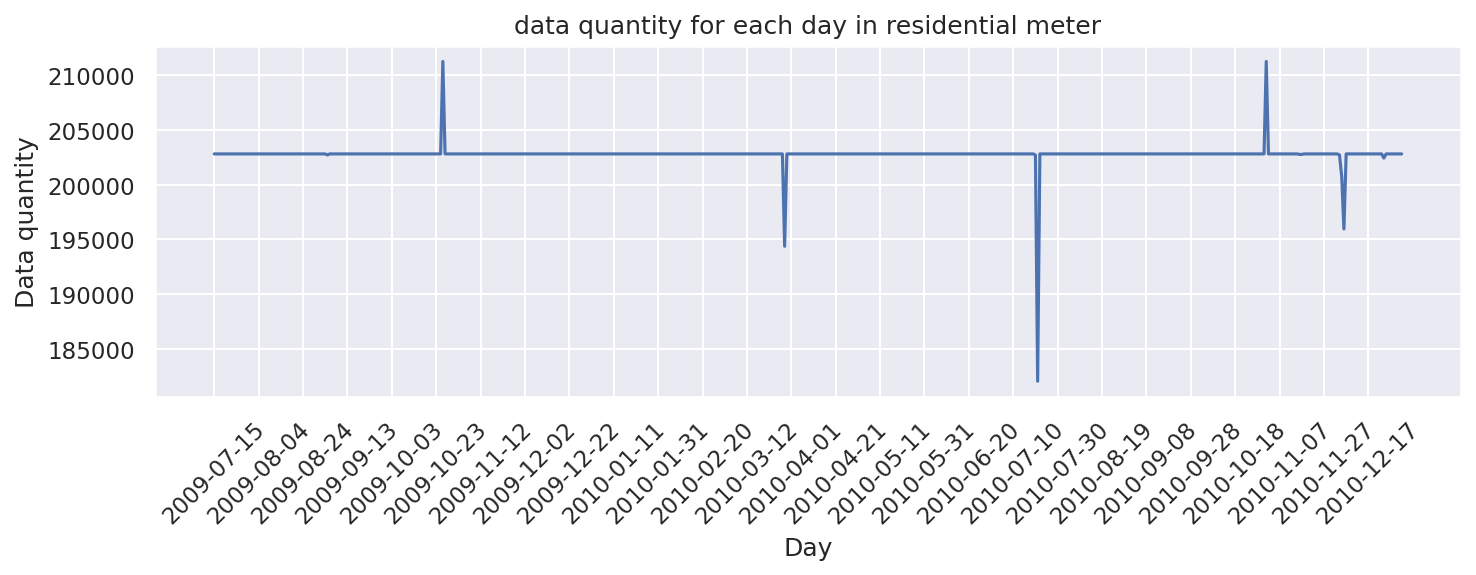

In [13]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity for each day in residential meter", save=True)

### select time interval

before drop Datetime between 19501 and 72948:  (108678770, 5)
after drop Datetime between 19501 and 72948:  (108475970, 5)
Saving figure data quantity in select time 2009.7.15-2010.12.31
(108475970, 5)
before drop Datetime between 73001 and 73048:  (108475970, 5)
after drop Datetime between 73001 and 73048:  (0, 5)


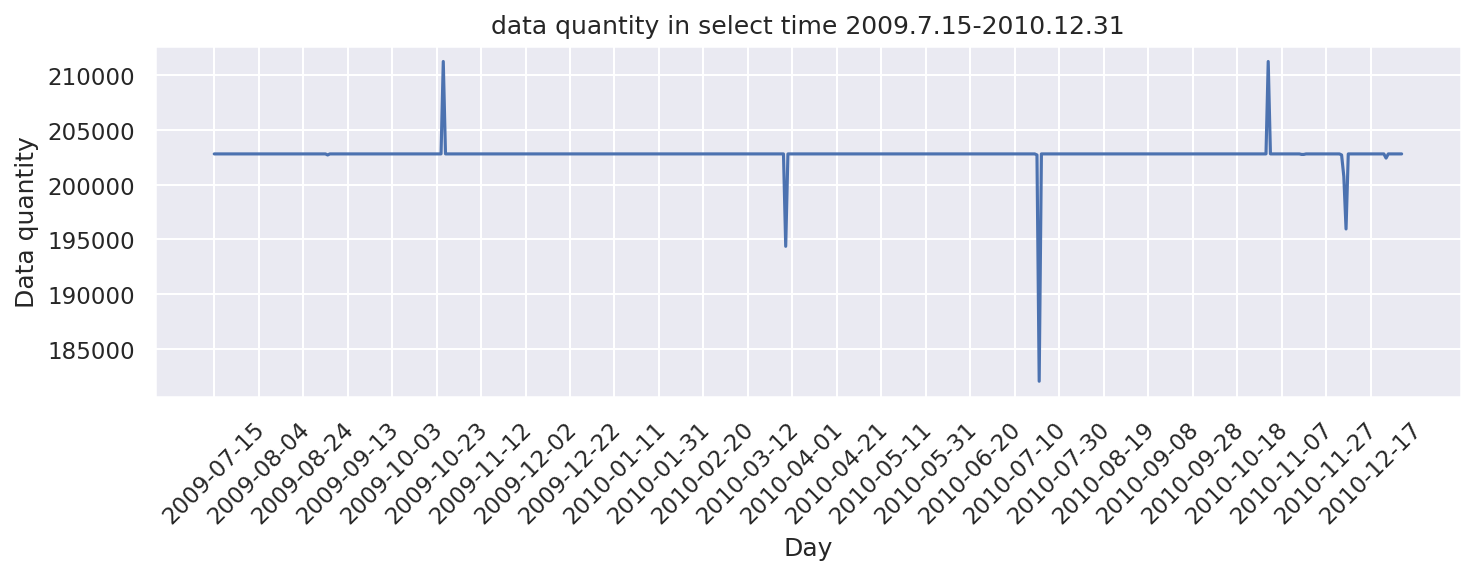

In [14]:
load_data = data_cleaning_select_time(load_data,19501,72948)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity in select time 2009.7.15-2010.12.31", save=True)
print(load_data.shape)
data_20110101 = data_cleaning_select_time(load_data,73001,73048)

### drop more than 48 hours

before drop Time: (108475970, 5)
after drop Time:  (108459070, 5)
Saving figure drop data more than 48 hours a day
(108459070, 5)


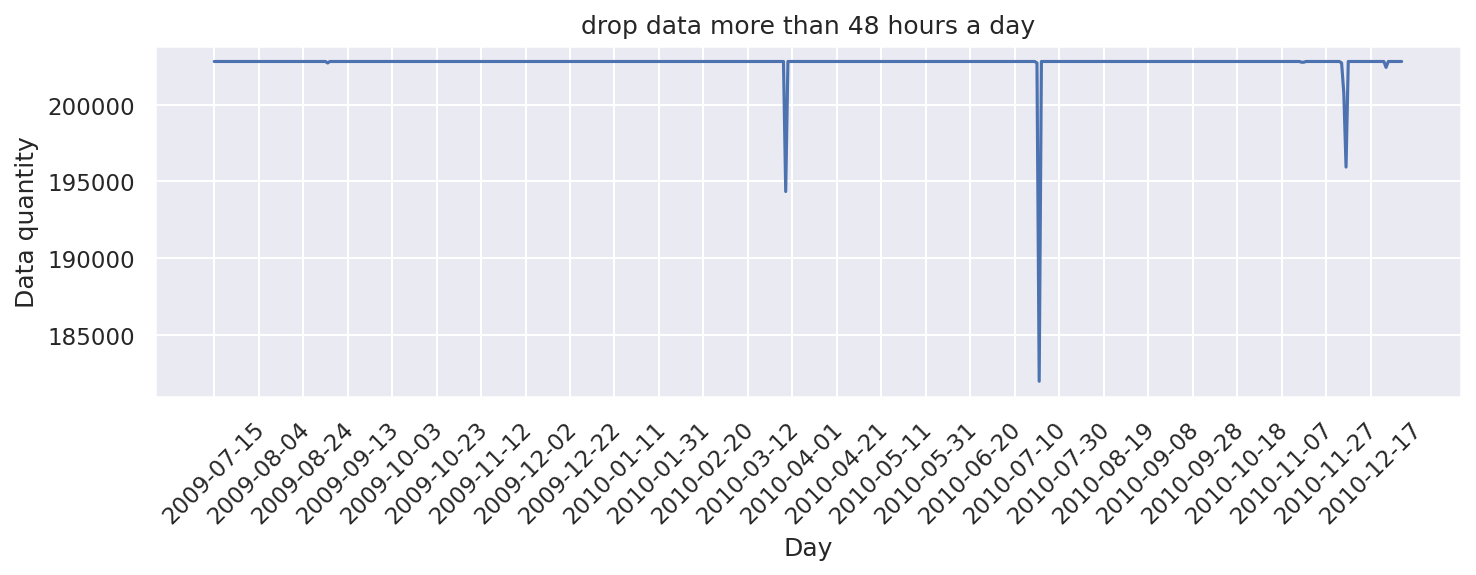

In [15]:
load_data = data_cleaning_drop_48(load_data)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data more than 48 hours a day", save=True)
print(load_data.shape)

### drop missing value

 2010-12-24    202416
 2010-12-05    200736
 2010-12-06    195936
 2010-03-29    194350
 2010-07-21    182016

Saving figure drop data with day missing
(107483616, 5)


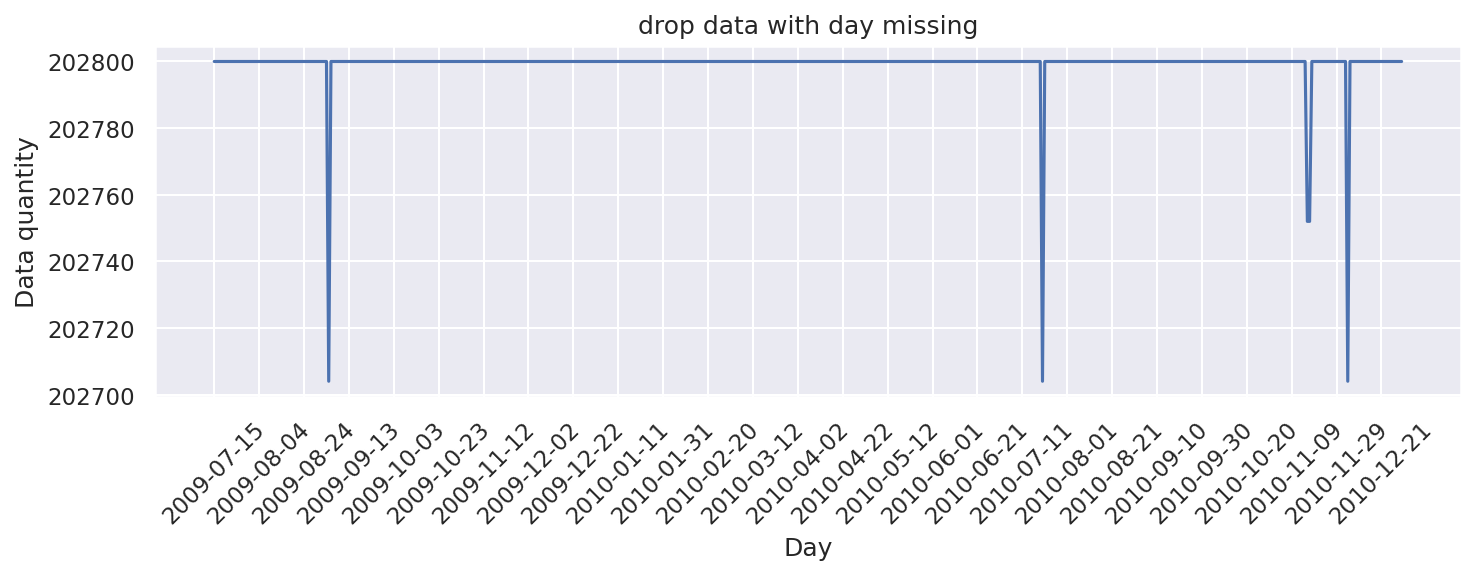

In [16]:
# drop data with day missing
drop_Day_missing = ["2010-03-29", "2010-12-24", "2010-12-05", "2010-12-06", "2010-07-21"]
load_data = drop_meter_from_df(load_data, "Day", drop_Day_missing)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data with day missing", save=True)
print(load_data.shape)

### replace missing value

 2010-11-17    202752
 2010-11-16    202752
 2009-09-04    202704
 2010-07-20    202704
 2010-12-04    202704

In [17]:
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-16"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-17"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2009-09-04"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-07-20"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-12-04"]["MeterID"].unique()))

{4463}
{4463}
{5313, 2715}
{3433, 5181}
{2728, 1505}


In [18]:
load_data = replace_missing_value(load_data, 4463, "2010-11-15", "2010-11-16", 1)
load_data = replace_missing_value(load_data, 4463, "2010-11-14", "2010-11-17", 1)
load_data = replace_missing_value(load_data, 2715, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 5313, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 3433, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 5181, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 1505, "2010-12-03", "2010-12-04", 1)
load_data = replace_missing_value(load_data, 2728, "2010-12-03", "2010-12-04", 1)

,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
22608208,4463,2010-11-16,1,0.479,68401
22608209,4463,2010-11-16,2,0.409,68402


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
22608160,4463,2010-11-17,1,0.441,68301
22608161,4463,2010-11-17,2,0.405,68302


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
2371104,2715,2009-09-04,1,0.089,24601
2371105,2715,2009-09-04,2,0.048,24602


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
2379264,5313,2009-09-04,1,0.154,24601
2379265,5313,2009-09-04,2,0.179,24602


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
17088619,3433,2010-07-20,1,0.611,56501
17088620,3433,2010-07-20,2,0.253,56502


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
17107983,5181,2010-07-20,1,0.558,56501
17107988,5181,2010-07-20,2,0.548,56502


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
23198590,1505,2010-12-04,1,0.0,70201
23198591,1505,2010-12-04,2,0.0,70202


,MeterID,Day,Time,Electricity,Datetime


,MeterID,Day,Time,Electricity,Datetime
23201700,2728,2010-12-04,1,0.923,70201
23201701,2728,2010-12-04,2,0.253,70202


Saving figure fill data with day missing
(107484000, 5)


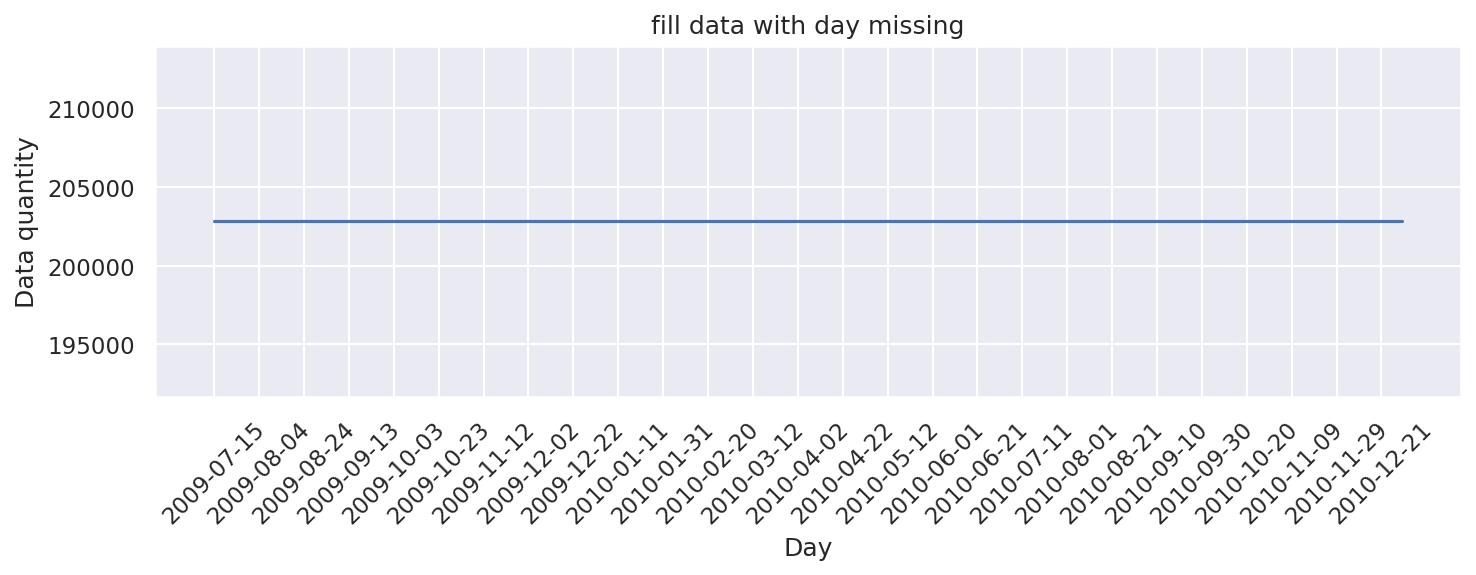

In [19]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="fill data with day missing", save=True)
print(load_data.shape)

In [20]:
del data
del d
del df_sme
del d_is_res
del res_list
del d_is_res_and_date
del res_data_list
gc.collect()

19085

## Meter grouping

In [21]:
pretty_data = load_data.sort_values(by=['MeterID', 'Day'])

In [22]:
# FDI CONST
NUMBER_OF_DAYS = len(pretty_data["Day"].unique())
NUMBER_OF_HALF_HOURS = NUMBER_OF_DAYS * 48
AREA_NUM = 10
TOTAL_METER = len(pretty_data.groupby("MeterID")["MeterID"].unique())
METER_IN_RANGE = round(len(pretty_data.groupby("MeterID")["MeterID"].unique()) / AREA_NUM)

In [23]:
NUMBER_OF_DAYS, NUMBER_OF_HALF_HOURS, TOTAL_METER, METER_IN_RANGE

(530, 25440, 4225, 422)

In [24]:
# split data into groups
def split_data_to_group(target_df, areas):
    data_group = {}
    for group in range(areas):
        if group == (AREA_NUM - 1):
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)+NUMBER_OF_HALF_HOURS* (TOTAL_METER % areas)]
        else:
            data_group[group] = target_df[METER_IN_RANGE*group*(NUMBER_OF_HALF_HOURS) : METER_IN_RANGE*(group+1)*(NUMBER_OF_HALF_HOURS)]
    return data_group

In [25]:
# split data into 10 groups
data_group = split_data_to_group(pretty_data, AREA_NUM)

## FDI

In [26]:
class FdiGenerator:
    def __init__(self):
        self.alpha_max = 0.8
        self.alpha_min = 0.2
    
    # x is the origin value

    def fdi_1(self, x):
        fdi =  x * self.get_alpha()
        return fdi

    def fdi_2(self, x, df_max):
        alpha = self.get_alpha()
        gamma = alpha * df_max
        return gamma if (x > gamma) else x

    def fdi_3(self, x, df_max):
        gamma = np.random.uniform(0, 1) * df_max
        return max((x - gamma), 0)
    
    def fdi_4(self, x, index, total_index):
        t2 = np.random.randint(0, 20)
        t1 = np.random.randint(t2, 24)
        if index > t2 and index < t2:
            return 0
        return x
    
    def fdi_5(self, x, index):
        alpha = self.get_alpha()
        return x * alpha
    
    def fdi_6(self, avg_x):
        alpha = self.get_alpha()
        return avg_x * alpha
    
    def get_alpha(self):
        return np.random.uniform(self.alpha_min, self.alpha_max)
    
    def get_random_mode(self):
        # return an integer in range from 1 to 6
        fdi_method = np.random.randint(1, 7)
        return fdi_method
    
    def random_fdi(self, fdi_method, x, df, index):
        # return a fdi value with fdi_method provided
        if fdi_method == 1:
            return self.fdi_1(x)
        elif fdi_method == 2:
            return self.fdi_2(x, df.max())
        elif fdi_method == 3:
            return self.fdi_3(x, df.max())
        elif fdi_method == 4:
            return self.fdi_4(x, index, df.shape[0])
        elif fdi_method == 5:
            return self.fdi_5(x, index)
        else:
            return self.fdi_6(df.mean())

In [27]:
def split_group(group, total_meter, area_num, group_meter, total_day, ntl_meter_ratio, ntl_day_ratio):
    # ex: split_group(data_group, total_meter = 2044, group_meter = 204, total_day = 299, ntl_meter_ratio = 0.1, ntl_day_ratio = 0.5)

    ntl_num = round(group_meter * ntl_meter_ratio) # ntl_num = how many number of ntl meters
    ntl_day_num = round(total_day * ntl_day_ratio) # ntl_day_num = how many days are fdi for ntl meters
    
    np.random.seed(42)
    
    final_data_group = []
    origin_data_group = []
    data_group = copy.deepcopy(group) 
    
    # iterate through 10 area
    for group, data in data_group.items():
        
        final_data = {}
        origin_data = {}

        normal_data = []
        fdi_data = []
        origin_fdi_data = []

        if group == (area_num - 1): # the last group will have more data for the rest of the meters
            num = total_meter - group_meter * (area_num -1)
        else:
            num = group_meter

        #split total meter into normal meters and fdi meters
        rs = ShuffleSplit(n_splits=1, test_size=ntl_num)
        for normal_index, fdi_index in rs.split(range(num)):
            for index in normal_index:
                normal_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])
            for index in fdi_index:
                fdi_data.append(data[index*(NUMBER_OF_HALF_HOURS):(index+1)*(NUMBER_OF_HALF_HOURS)])

        origin_fdi_data = copy.deepcopy(fdi_data)
            
        for index in tq.tqdm(range(len(fdi_data))):
            
            dataframe = fdi_data[index]
            fdi_dataframe = np.zeros((NUMBER_OF_HALF_HOURS))
            fdi_label = np.zeros((NUMBER_OF_HALF_HOURS))
            normal_label = np.zeros((NUMBER_OF_HALF_HOURS))
            
            # split total day into normal and fdi day with the ntl_day_num
            rs = ShuffleSplit(n_splits=1, test_size=ntl_day_num, random_state=42)
            for normal_day, fdi_day in rs.split(range(total_day)):
                normal_day = normal_day
                fdi_day = fdi_day
            
            # set normal data in normal days
            for day in range(len(normal_day)):
                for i in range(normal_day[day]*48, (normal_day[day]+1)*48):
                    fdi_dataframe[i] = dataframe["Electricity"].iloc[[i]]
                    fdi_label[i] = 0
            
            # process FDI in fdi days
            for day in range(len(fdi_day)):
                for i in range(fdi_day[day]*48, (fdi_day[day]+1)*48):
                    
                    # one day has 48 data, so every 48 will change a fdi mode
                    if i%48 == 0:
                        fdi_method = FDI.get_random_mode()
                    
                    origin_value = dataframe["Electricity"].iloc[i]
                    fdi_dataframe[i] = FDI.random_fdi(fdi_method, origin_value, dataframe["Electricity"], i)
                    fdi_label[i] = 1

            fdi_data[index]["Electricity"] = fdi_dataframe
            fdi_data[index]["FDI"] = fdi_label #for fdi day, fdi flag is 1, otherwise, flag is 0            
            
        final_data["normal"] = normal_data
        final_data["fdi"] = fdi_data
        final_data_group.append(final_data) 

        origin_data["normal"] = normal_data
        origin_data["fdi"] = origin_fdi_data
        origin_data_group.append(origin_data)
        
        
#         return final_data_group, origin_data_group

    return final_data_group, origin_data_group

In [28]:
FDI = FdiGenerator()
final_data_group, origin_data_group = split_group(data_group, total_meter=TOTAL_METER, area_num=AREA_NUM, total_day=NUMBER_OF_DAYS, group_meter=METER_IN_RANGE, ntl_meter_ratio=0.1, ntl_day_ratio=0.5)

  0%|          | 0/42 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

In [131]:
for i in final_data_group:
    print(i['normal'][0]['FDI'])
    t = i['fdi'][0]
    print(i['fdi'][0]['FDI'])
    break

192076      0.0
192077      0.0
192078      0.0
192079      0.0
192080      0.0
           ... 
24357497    0.0
24357498    0.0
24357499    0.0
24357500    0.0
24357501    0.0
Name: FDI, Length: 25440, dtype: float64
206066      1.0
206067      1.0
206068      1.0
206069      1.0
206070      1.0
           ... 
24375545    1.0
24375546    1.0
24375547    1.0
24375548    1.0
24375549    1.0
Name: FDI, Length: 25440, dtype: float64


In [153]:
# smart meter to csv
smart_meter_list = []
smart_meter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI'])
pbar = tqdm(final_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        fdi_list = meter['FDI'].to_numpy()
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            fdi = fdi_list[i*48]
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': fdi}
            smart_meter_list.append(se)
            
    for meter in area['normal']:
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': 0}
            smart_meter_list.append(se)


# df = pd.DataFrame(np.array(smart_meter_list).reshape(-1, 6), columns=["MeterID","Day","Time","Electricity","Datetime", "FDI"])
# df.head()
# df = df[["MeterID","Day","Time","Electricity","FDI"]]
# e = df.to_csv(index=False)
# f = open('smart_meter.csv','w')
# f.write(e) #Give your csv text here.
# f.close()

  0%|          | 0/10 [00:00<?, ?it/s]

In [154]:
len(smart_meter_list), len(smart_meter_list[0]), 

(2239250, 3)

In [155]:
df = pd.DataFrame(smart_meter_list)
df.head()

,MeterID,Day,FDI
0,1236,2009-07-15,1.0
1,1236,2009-07-16,0.0
2,1236,2009-07-17,1.0
3,1236,2009-07-18,1.0
4,1236,2009-07-19,0.0


In [156]:
df['FDI'].value_counts()

0.0    2127950
1.0     111300
Name: FDI, dtype: int64

In [157]:
e = df.to_csv(index=False)
f = open('CSV/FDI.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [42]:
# smart meter to csv
Y = []
smart_meter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI','Electricity'])
pbar = tqdm(final_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        Y.append([1])
    for meter in area['normal']:
        Y.append([0])

  0%|          | 0/10 [00:00<?, ?it/s]

In [43]:
len(Y)

4225

In [46]:
df = pd.DataFrame(Y, columns=["FDI"])
df.head()

,FDI
0,1
1,1
2,1
3,1
4,1


In [47]:
e = df.to_csv(index=False)
f = open('CSV/fdi_4225.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [ ]:
smart_meter_list

In [ ]:
# df = pd.DataFrame(np.array(smart_meter_list).reshape(-1, 6), columns=["MeterID","Day","Time","Electricity","Datetime", "FDI"])
# df.head()
# df = df[["MeterID","Day","Time","Electricity","FDI"]]
# e = df.to_csv(index=False)
# f = open('smart_meter.csv','w')
# f.write(e) #Give your csv text here.
# f.close()